<h1> GAN comparison on Kaggle Credit Card Fraud Data </h1><br>
Cody Nash<br>
Development Notebook
<hr>

This notebook accompanies the Toptal blog found <a href='https://www.toptal.com/machine-learning/generative-adversarial-networks'>here</a>.<br>
<hr>


<a id="TOC"></a><h2>Table of Contents</h2>
<br>
<a href='#Setup'> Setup</a><br>
<br>
<a href='#EDA'> Exploratory Data Analysis (EDA)</a><br>
<a href='#xgboost fraud detection'> xgboost fraud detection</a><br>
<a href='#Classification'> Classification of fraud data</a><br>
<br>
<a href="#GAN setup"> GAN setup and training</a><br>
<br>
<a href="#Compare GAN Output"> Compare GAN Output</a><br>
<a href="#Generated Data Testing"> Generated Data Testing</a><br>
<a href="#Summary"> Summary of Training Data</a><br>
<br>
<a href="#DRAGAN"> DRAGAN testing</a><br>
<br>
<h3>Blog Figures:</h3>
<br>
<a href="#Fig3"> Figure 3: Data Distributions by Feature and Class</a><br>
<a href="#Fig5"> Figure 5: Comparison of GAN Outputs</a><br>
<a href="#Fig6"> Figure 6: Accuracy of Generated Data Detection</a><br>
<a href="#Fig7"> Figure 7: Differences in Critic Loss</a><br>
<a href="#Fig8"> Figure 8: Effects of Additional Data</a><br>

<a id="Setup"><h1>Setup</h1></a>

<a href='#TOC'>Table of contents</a>
<br><br>

- Load libraries
- Load common functions
- Load stored datasets
- Use linux for xgboost and tensorflow

In [1]:

# import library

import psutil ; print(list(psutil.virtual_memory())[0:2])

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

import xgboost as xgb

import pickle

import gc
gc.collect()
print(list(psutil.virtual_memory())[0:2])


# Load custom functions

import GAN_171103

# For reloading after making changes
import importlib
importlib.reload(GAN_171103) 
from GAN_171103 import *


# Load data

col_name=[  "btc_trns_avg" ,
  "btc_trns_sum" ,
  "btc_trns_min" ,
  "btc_trns_max" ,
  "btc_recv_avg" ,
  "btc_recv_sum" ,
  "btc_recv_min" ,
  "btc_recv_max" ,
  "trns_value_avg" ,
  "trns_value_sum" ,
  "trns_value_min" ,
  "trns_value_max" ,
  "recv_value_avg" ,
  "recv_value_sum" ,
  "recv_value_min" ,
  "recv_value_max" ,
  "tx_fee_trns_avg" ,
  "tx_fee_recv_avg" ,
  "sib_input_avg",
  "sib_input_out_avg",
  "sib_output_avg",
  "sib_output_in_avg",
  "sibaddr_trns_avg",
  "sibaddr_trns_out_avg",
  "sibaddr_recv_avg",
  "sibaddr_recv_in_avg",
  "txsize_trns_avg",
  "txsize_recv_avg",
  "rel_tx_trns_cnt",
  "rel_tx_recv_cnt",
  ]

exchange_data = pd.read_csv("data/exchange_59.csv", names = col_name)
silkroad_data = pd.read_csv("data/silkroad_20_21.csv", names = col_name)
#print(data.shape)




#data.head(3)

# data columns will be all other columns except class

label_cols = ['Class']
exchange_data['Class'] = 0
silkroad_data['Class'] = 1


exchange_data = exchange_data[:100000]
silkroad_data = silkroad_data[:10000]

EXCHANGE_TX_NUM = exchange_data.shape[0]
SILKROAD_TX_NUM = silkroad_data.shape[0]
print(EXCHANGE_TX_NUM)
print(SILKROAD_TX_NUM)# - (SILKROAD_TX_NUM%2))

data = pd.concat([exchange_data,silkroad_data], ignore_index=True).copy()
#data drop


#data= data.drop(['V0'],axis=1)
 
    
data_cols = list(data.columns[ data.columns != 'Class' ])
print(data_cols)
print('# of data columns: ',len(data_cols))

# 300000 normal transactions (class 0)
# 300000 fraud transactions (class 1)

data.groupby('Class')['Class'].count()



# Total nulls in dataset (sum over rows, then over columns)

data.isnull().sum().sum()


# Duplicates? Yes

normal_duplicates = sum( data.loc[ data.Class==0 ].duplicated() )
fraud_duplicates = sum( data.loc[ data.Class==1 ].duplicated() )
total_duplicates = normal_duplicates + fraud_duplicates

print( 'Normal duplicates', normal_duplicates )
print( 'Fraud duplicates', fraud_duplicates )
print( 'Total duplicates', total_duplicates )
print( 'Fraction duplicated', total_duplicates / len(data) )

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

features = ['btc_trns_avg', 'btc_trns_sum', 'btc_trns_min', 'btc_trns_max', 'btc_recv_avg', 'btc_recv_sum', 'btc_recv_min', 'btc_recv_max', 'trns_value_avg', 'trns_value_sum', 'trns_value_min', 'trns_value_max', 'recv_value_avg', 'recv_value_sum', 'recv_value_min', 'recv_value_max', 'tx_fee_trns_avg', 'tx_fee_recv_avg', 'sib_input_avg', 'sib_input_out_avg', 'sib_output_avg', 'sib_output_in_avg', 'sibaddr_trns_avg', 'sibaddr_trns_out_avg', 'sibaddr_recv_avg', 'sibaddr_recv_in_avg', 'txsize_trns_avg', 'txsize_recv_avg', 'rel_tx_trns_cnt', 'rel_tx_recv_cnt']
x = data.loc[:, features].values

y = data.loc[:,['Class']].values

x = StandardScaler().fit_transform(x)            
pca = PCA(n_components=0.99)
principalComponents = pca.fit_transform(x)
FEATURE_NUM = principalComponents.shape[1]
principalDf = pd.DataFrame(data = principalComponents,columns = ['V'+str(i) for i in range(FEATURE_NUM)])
print(principalDf)
#print(data['Class'])
#print(principalDf)
data = pd.concat([principalDf, data['Class']],axis=1).copy()


print(data.columns)
data_cols =  ['V'+str(i) for i in range(FEATURE_NUM)]
RAND_DIM = FEATURE_NUM + 1


[8589934592, 1780133888]


ModuleNotFoundError: No module named 'xgboost'

In [3]:
# Center and scale all data, only using the middle 99.8%, so outliers don't pull too much.
# First generate the percentile data for each feature

percentiles =  pd.DataFrame( np.array([ np.percentile( data[i], [ 0.1, 99.9 ] ) for i in data_cols ]).T,
                            columns=data_cols, index=['min','max'] )

percentile_means = \
    [ [ np.mean( data.loc[ (data[i]>percentiles[i]['min']) & (data[i]<percentiles[i]['max']) , i ] ) ]
     for i in data_cols ]

percentiles = percentiles.append( pd.DataFrame(np.array(percentile_means).T, columns=data_cols, index=['mean']) )

percentile_stds = \
    [ [ np.std( data.loc[ (data[i]>percentiles[i]['min']) & (data[i]<percentiles[i]['max']) , i ] ) ]
     for i in data_cols ]

percentiles = percentiles.append( pd.DataFrame(np.array(percentile_stds).T, columns=data_cols, index=['stdev']) )


# Center and scale the data using the percentile data we just generated


#data[data_cols] = ( data[data_cols] - percentiles.loc[ 'mean', data_cols ] ) / percentiles.loc[ 'stdev', data_cols ]

# # Or we can center and scale using all of the data

from sklearn.preprocessing import StandardScaler

data[data_cols] = StandardScaler().fit_transform(data[data_cols])


# There are outliers, 50-100 stdevs away from mean in several columns

plot_cols = data_cols
# plt.plot( np.log10( data[ plot_cols ].abs().max().values ) )
# plt.plot( data[ plot_cols ].abs().max().values / data[ plot_cols ].std().values / 10, label='max z/10' )
plt.plot( data.loc[ data.Class==1, plot_cols ].abs().max().values / data[ plot_cols ].std().values / 10, label='fraud max z/10' )
plt.plot( data.loc[ data.Class==0, plot_cols ].abs().max().values / data[ plot_cols ].std().values / 10, label='real max z/10' )
plt.plot( data[ plot_cols ].mean().values, label='mean' )
# plt.plot( data[ plot_cols ].abs().mean().values, label='abs mean' )
plt.plot( data[ plot_cols ].std().values, label='std' )
plt.xlabel('Feature')
plt.ylabel('z/10')
plt.legend() ; 

# Check Correlations
# Note no correlations among PCA transformed columns, as expected
corr0 = data.corr()

plt.imshow(corr0) ;

NameError: name 'data_cols' is not defined

In [ ]:
 

# Plot the data by each feature

axarr = [[]]*len(data_cols)
columns = 4
rows = int( np.ceil( len(data_cols) / columns ) )
f, fig = plt.subplots( figsize=(columns*3.5, rows*2) )

f.suptitle('Data Distributions by Feature and Class', size=16)

for i, col in enumerate(data_cols[:]):
    axarr[i] = plt.subplot2grid( (int(rows), int(columns)), (int(i//columns), int(i%columns)) )
    axarr[i].hist( [ data.loc[ data.Class == 0, col ], data.loc[ data.Class == 1, col ] ], label=['normal','fraud'], 
                          bins=np.linspace( np.percentile(data[col],0.1), np.percentile(data[col],95), 30 ),
                          normed=True )
    axarr[i].set_xlabel(col, size=12)
    axarr[i].set_ylim([0,2])
    axarr[i].tick_params(axis='both', labelsize=10)
    if i == 0: 
        legend = axarr[i].legend()
        legend.get_frame().set_facecolor('white')
    if i%4 != 0 : 
        axarr[i].tick_params(axis='y', left='off', labelleft='off')
    else:
        axarr[i].set_ylabel('Fraction',size=12)

plt.tight_layout(rect=[0,0,1,0.95]) # xmin, ymin, xmax, ymax
# plt.savefig('plots/Engineered_Data_Distributions.png')
plt.show()



# Save engineered dataset for use in analysis
# Save as pickle for faster reload
pkl_file_name = "bitcoin.engineered.pkl" # 'credicard.engineered.pkl'
pickle.dump(data, open('data/' + pkl_file_name,'wb'))



# Load engineered dataset from EDA section

data = pickle.load(open('data/' + pkl_file_name ,'rb'))
data = data.fillna(0)

# data columns will be all other columns except class
data_cols = list(data.columns[ data.columns != 'Class' ])
label_cols = ['Class']

print(data_cols)
print('# of data columns: ',len(data_cols))



# Add KMeans generated classes to fraud data - see classification section for more details on this

import sklearn.cluster as cluster

train = data.loc[ data['Class']==1 ].copy()

algorithm = cluster.KMeans
args, kwds = (), {'n_clusters':2, 'random_state':0}
labels = algorithm(*args, **kwds).fit_predict(train[ data_cols ])

print( pd.DataFrame( [ [np.sum(labels==i)] for i in np.unique(labels) ], columns=['count'], index=np.unique(labels) ) )

fraud_w_classes = train.copy()
fraud_w_classes['Class'] = labels
#print(fraud_w_classes.loc[fraud_w_classes.Class == 1])

<a id="xgboost fraud detection"><h1>xgboost fraud detection</h1></a>

<a href='#TOC'>Table of contents</a>
<br><br>

- Here we'll use the xgboost algorithm to detect fraud cases

In [5]:

# define the columns we want to test on, in case we want to use less than the full set

test_cols = data.columns

# test_cols = data.columns[ data.columns != 'Amount' ]

print("len of test columns : ", len(test_cols))
print("test colum : ", test_cols)


# Define some custom metric functions for use with the xgboost algorithm
# https://github.com/dmlc/xgboost/blob/master/demo/guide-python/custom_objective.py

from sklearn.metrics import recall_score, precision_score, roc_auc_score

def recall(preds, dtrain):
    labels = dtrain.get_label()
    return 'recall',  recall_score(labels, np.round(preds))

def precision(preds, dtrain):
    labels = dtrain.get_label()
    return 'precision',  precision_score(labels, np.round(preds))

def roc_auc(preds, dtrain):
    labels = dtrain.get_label()
    return 'roc_auc',  roc_auc_score(labels, preds)


# Set up the test and train sets

np.random.seed(0)

n_real = np.sum(data.Class==0) # 200000
n_test = np.sum(data.Class==1) # 492
train_fraction = 0.7
fn_real = int(n_real * train_fraction)
fn_test = int(n_test * train_fraction)

real_samples = data.loc[ data.Class==0, test_cols].sample(n_real, replace=False).reset_index(drop=True)
test_samples = data.loc[ data.Class==1, test_cols].sample(n_test, replace=False).reset_index(drop=True)

train_df = pd.concat([real_samples[:fn_real],test_samples[:fn_test]],axis=0,ignore_index=True).reset_index(drop=True)
# train_df = pd.concat([real_samples[:fn_test],test_samples[:fn_test]],axis=0,ignore_index=True).reset_index(drop=True)

test_df = pd.concat([real_samples[fn_real:],test_samples[fn_test:]],axis=0,ignore_index=True).reset_index(drop=True)
print( 'classes 0, 1: ', n_real, n_test )
print( 'train, test: ', len(train_df), len(test_df) )

X_col = test_df.columns[:-1]
y_col = test_df.columns[-1]
dtrain = xgb.DMatrix(train_df[X_col], train_df[y_col], feature_names=X_col)
dtest = xgb.DMatrix(test_df[X_col], test_df[y_col], feature_names=X_col)


len of test columns :  16
test colum :  Index(['V0', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'Class'],
      dtype='object')
classes 0, 1:  100000 10000
train, test:  77000 33000


In [6]:

# Run the xgboost algorithm, maximize recall on the test set

results_dict = {}

xgb_params = {
#     'max_depth': 4,
    'objective': 'binary:logistic',
    'random_state': 0,
    'eval_metric': 'auc', # auc, error
#     'tree_method': 'hist'
#     'grow_policy': 'lossguide' # depthwise, lossguide
}

xgb_test = xgb.train(xgb_params, dtrain, num_boost_round=100, 
                     verbose_eval=False,
                     early_stopping_rounds=20, 
                     evals=[(dtrain,'train'),(dtest,'test')],
                     evals_result = results_dict,              
                     feval = recall, maximize=True
#                      feval = roc_auc, maximize=True
                    )

y_pred = xgb_test.predict(dtest, ntree_limit=xgb_test.best_iteration+1)
y_true = test_df['Class'].values
print( 'best iteration: ', xgb_test.best_iteration )
print(recall( y_pred, dtest ))
print(precision( y_pred, dtest ) )
print( roc_auc( y_pred, dtest ) )
# print( 'Accuracy: {:.3f}'.format(SimpleAccuracy(y_pred, y_true)) )
SimpleMetrics( np.round(y_pred), y_true)

best iteration:  99
('recall', 0.9523333333333334)
('precision', 0.9704483695652174)
('roc_auc', 0.9984842055555556)
Confusion Matrix


,Pred 0,Pred 1
True 0,29913,87
True 1,143,2857


Accuracy : 0.993030303030303


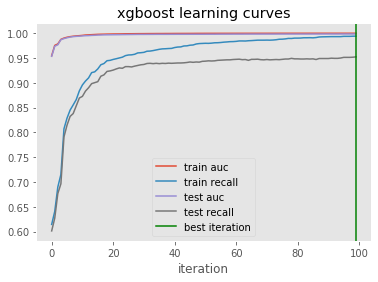

In [7]:

# Let's look at how the metrics changed on the train and test sets as more trees were added

for i in results_dict:
    for err in results_dict[i]:
        plt.plot(results_dict[i][err], label=i+' '+err)   
plt.axvline(xgb_test.best_iteration, c='green', label='best iteration')
plt.xlabel('iteration')
# plt.ylabel(err)
plt.title('xgboost learning curves')
plt.legend()
plt.grid() ;

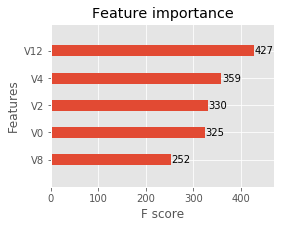

In [11]:
# Plot feature importances

fig, ax = plt.subplots(1, 1, figsize=(4, 3))
xgb.plot_importance(xgb_test, max_num_features=5, height=0.4, ax=ax);

In [8]:

# Generate list of features sorted by importance in detecting fraud

import operator
x = xgb_test.get_fscore()
sorted_x = sorted(x.items(), key=operator.itemgetter(1), reverse=True)

# print( 'Top eight features for fraud detection: ', [ i[0] for i in sorted_x[:8] ] )

sorted_cols = [i[0] for i in sorted_x] + ['Class']
print( sorted_cols )
data = data[ sorted_cols ].copy()
data.head(3)

['V12', 'V4', 'V2', 'V0', 'V8', 'V1', 'V10', 'V6', 'V13', 'V3', 'V9', 'V14', 'V7', 'V5', 'V11', 'Class']


,V12,V4,V2,V0,V8,V1,V10,V6,V13,V3,V9,V14,V7,V5,V11,Class
0,0.147284,-0.002456,-0.597030,-0.073042,0.494101,0.338377,-0.194293,-0.149801,-0.015801,0.075793,-0.150496,-0.000372,-0.115100,-0.104993,-0.073648,0
1,-0.959691,0.173040,-0.367496,-0.040087,-1.411295,0.658346,0.821385,0.086081,-0.010701,0.088057,0.471582,-0.164848,0.291424,0.202963,0.309744,0
2,-0.960899,0.192696,-0.380293,-0.043084,-1.412785,0.653452,0.822004,0.081361,-0.010570,0.088154,0.476591,-0.164011,0.292857,0.207798,0.306000,0


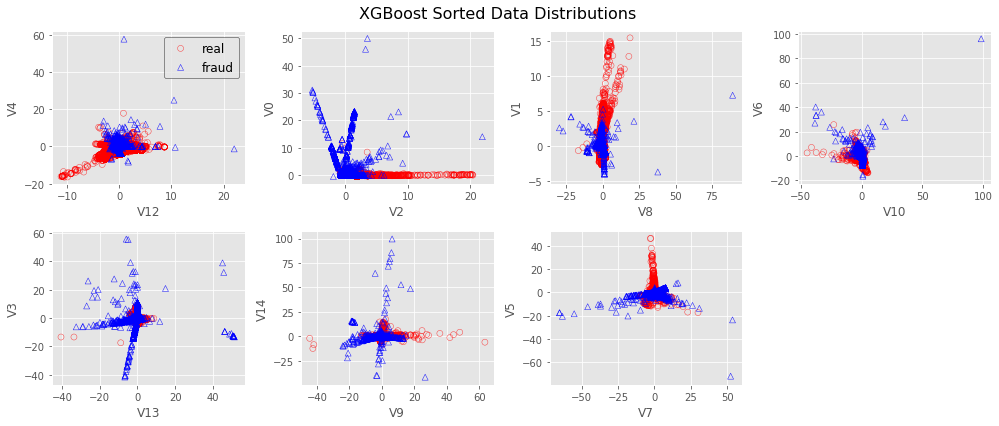

In [29]:

# Plot all of the training data with paired features sorted by importance
# This takes a while

colors = ['red','blue']
markers = ['o','^']
labels = ['real','fraud']
alphas = [0.7, 0.9]

columns = 4
rows = int( np.ceil( len(data_cols) / columns / 2 ) )
plt.figure( figsize=(columns*3.5, rows*3) )
plt.suptitle('XGBoost Sorted Data Distributions ', size=16)

train = train_df.copy()

for i in range( int(np.floor(len(sorted_x)/2)) )[:]:
    col1, col2 = sorted_x[i*2][0], sorted_x[i*2+1][0]
#     print(i,col1,col2)
    
    plt.subplot(rows,columns,i+1)  
    for group, color, marker, label, alpha in zip( train.groupby('Class'), colors, markers, labels, alphas ):
        plt.scatter( group[1][col1], group[1][col2], 
                         label=label, marker=marker, alpha=alpha,
                         edgecolors=color, facecolors='none' )         
    plt.xlabel(col1, size=12)
    plt.ylabel(col2, size=12)
    plt.tick_params(axis='both', labelsize=10)
    if i == 0: plt.legend(fontsize=12, edgecolor='black')

plt.tight_layout(rect=[0,0,1,0.95]) # xmin, ymin, xmax, ymax
plt.savefig('plots/XGB_Sorted_Data_Distributions.png')
plt.show()


In [30]:


# Lets look at the effect of the ratio of normal:fraud data in the dataset on recall and roc_auc
# We'll use cross validation to see if differences are significant


np.random.seed(0)

n_real = np.sum(data.Class==0) # 200000
n_test = np.sum(data.Class==1) # 492
real_samples = data.loc[ data.Class==0, test_cols].sample(n_real, replace=False).reset_index(drop=True)
test_samples = data.loc[ data.Class==1, test_cols].sample(n_test, replace=False).reset_index(drop=True)
X_col = data.columns[:-1]
y_col = data.columns[-1]

test_data=[]

# for i in [1]:
# for i in [0.1,0.5,1,2,10]:
for i in np.logspace(-1,2,8):
    print(i)
    train_df = pd.concat([real_samples[:int(n_test*i)],test_samples[:n_test]],axis=0,ignore_index=True).reset_index(drop=True)
    dtrain = xgb.DMatrix(train_df[X_col], train_df[y_col], feature_names=X_col)
    results = xgb.cv(xgb_params, dtrain, 
                     nfold=5, num_boost_round=100, early_stopping_rounds=10, seed=0,
                     feval=recall)
    test_data.append(list([i]) + list(results.tail(1).index) + list(results.tail(1).values[0]))
    
test_data = pd.DataFrame(test_data, columns=list(['ratio','best'])+list(results.columns))
test_data

0.1
0.2682695795279726
0.7196856730011519
1.9306977288832496
5.17947467923121
13.894954943731374
37.27593720314938
100.0


,ratio,best,train-auc-mean,train-auc-std,train-recall-mean,train-recall-std,test-auc-mean,test-auc-std,test-recall-mean,test-recall-std
0,0.100000,0,0.925236,0.009023,0.994349,0.001853,0.914650,0.006873,0.991796,0.002620
1,0.268270,0,0.961548,0.006064,0.989977,0.002592,0.952249,0.011086,0.985590,0.004907
2,0.719686,1,0.985719,0.001376,0.979253,0.001219,0.981635,0.003501,0.972378,0.003033
3,1.930698,1,0.985347,0.002272,0.952850,0.009414,0.982896,0.001905,0.948061,0.012392
4,5.179475,0,0.975711,0.002933,0.823806,0.033440,0.973193,0.001264,0.811199,0.025563
5,13.894955,1,0.970776,0.001552,0.637779,0.022135,0.968540,0.001472,0.629821,0.016856
6,37.275937,1,0.970776,0.001552,0.637779,0.022135,0.968540,0.001472,0.629821,0.016856
7,100.000000,1,0.970776,0.001552,0.637779,0.022135,0.968540,0.001472,0.629821,0.016856


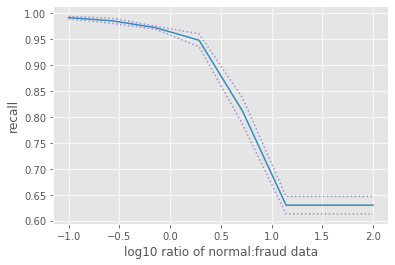

In [31]:

# Recall decreases as more normal data is added

# metric = 'auc'
metric = 'recall'
# xs = test_data['ratio'].values
xs = np.log10(test_data['ratio'].values)
ys = test_data['test-'+metric+'-mean'].values
stds = test_data['test-'+metric+'-std'].values
plt.plot(xs,ys,c='C1')
plt.plot(xs,ys+stds,linestyle=':',c='C2')
plt.plot(xs,ys-stds,linestyle=':',c='C2')
plt.xlabel('log10 ratio of normal:fraud data')
plt.ylabel(metric)
# plt.ylim([0.96,1.01])
plt.show()

   count
1  10000
0 KMeans
1 Agglomerative
2 HDBSCAN


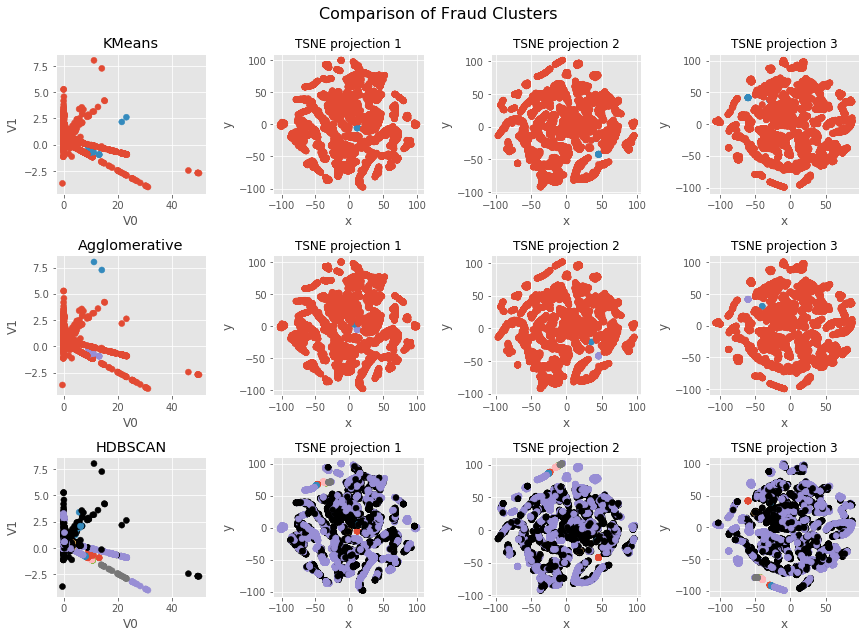

   count
0   9976
1     24
[('V13', 7), ('V7', 4), ('V8', 3), ('V2', 2), ('V1', 2), ('V4', 1), ('V9', 1)]
7


In [38]:


# load clustering libraries

import sklearn.cluster as cluster



# hdbscan not in kaggle/python at present

!pip install hdbscan
import hdbscan



# Set up training set to consist of only fraud data

train = data.loc[ data['Class']==1 ].copy()

print( pd.DataFrame( [ [np.sum(train['Class']==i)] for i in np.unique(train['Class']) ], columns=['count'], index=np.unique(train['Class']) ) )

# train = pd.get_dummies(train, columns=['Class'], prefix='Class')
label_cols = [ i for i in train.columns if 'Class' in i ]
data_cols = [ i for i in train.columns if i not in label_cols ]
train_no_label = train[ data_cols ]



# TSNE is an interesting method to map higher dimensional data into two dimensions
# http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

# Note TSNE map may not be what you might think:
# https://distill.pub/2016/misread-tsne/

# Create multiple projections to compare results from different random states

from sklearn.manifold import TSNE

projections = [ TSNE(random_state=i).fit_transform(train_no_label) for i in range(3) ]



# Now we'll compare some different clustering algorithms
# https://github.com/scikit-learn-contrib/hdbscan/blob/master/docs/comparing_clustering_algorithms.rst

algorithms = [ 
#     [ 'KMeans', cluster.KMeans, (), {'random_state':0} ],
    [ 'KMeans', cluster.KMeans, (), {'n_clusters':2, 'random_state':0} ],
#     [ 'KMeans 3', cluster.KMeans, (), {'n_clusters':3, 'random_state':0} ],
#     [ 'Agglomerative', cluster.AgglomerativeClustering, (), {} ],
    [ 'Agglomerative', cluster.AgglomerativeClustering, (), {'linkage': 'ward', 'n_clusters': 3} ],
#     [ 'Agg. Ave 3', cluster.AgglomerativeClustering, (), {'linkage': 'average', 'n_clusters': 3} ],
#     [ 'Agg. Complete 3', cluster.AgglomerativeClustering, (), {'linkage': 'complete', 'n_clusters': 3} ],
#     [ 'DBSCAN', cluster.DBSCAN, (), {'eps':0.025} ],
#     [ 'HDBSCAN', hdbscan.HDBSCAN, (), {} ],
    [ 'HDBSCAN', hdbscan.HDBSCAN, (), {'min_cluster_size':10, 'min_samples':1, } ],
#     [ 'HDBSCAN 2 10', hdbscan.HDBSCAN, (), {'min_cluster_size':2, 'min_samples':10, } ],
#     [ 'HDBSCAN 10 10 ', hdbscan.HDBSCAN, (), {'min_cluster_size':10, 'min_samples':10, } ],
]

rows = len(algorithms)
columns = 4
plt.figure(figsize=(columns*3, rows*3))

for i, [name, algorithm, args, kwds] in enumerate(algorithms):
    print(i, name)

    labels = algorithm(*args, **kwds).fit_predict(train_no_label)
#     labels = algorithm(*args, **kwds).fit_predict(projections[0])
    
#     print( pd.DataFrame( [ [np.sum(labels==i)] for i in np.unique(labels) ], columns=['count'], index=np.unique(labels) ) )
    
    colors = np.clip(labels,-1,9)
    colors = [ 'C'+str(i) if i>-1 else 'black' for i in colors ]
    
    plt.subplot(rows,columns,i*columns+1)
    plt.scatter(train_no_label[data_cols[0]], train_no_label[data_cols[1]], c=colors)
    plt.xlabel(data_cols[0]), plt.ylabel(data_cols[1])
    plt.title(name)

    for j in range(3):
        plt.subplot(rows,columns,i*columns+1+j+1)
        plt.scatter(*(projections[j].T), c=colors) 
        plt.xlabel('x'), plt.ylabel('y')
        plt.title('TSNE projection '+str(j+1),size=12)
        
#     break

plt.suptitle('Comparison of Fraud Clusters', size=16)
plt.tight_layout(rect=[0,0,1,0.95])
plt.savefig('plots/Fraud_Cluster_Diagram.png')
plt.show()


# Now pick a set of labels and add to the dataset

algorithm = cluster.KMeans
args, kwds = (), {'n_clusters':2, 'random_state':0}
labels = algorithm(*args, **kwds).fit_predict(train_no_label)
# labels = algorithm(*args, **kwds).fit_predict(projections[0])

print( pd.DataFrame( [ [np.sum(labels==i)] for i in np.unique(labels) ], columns=['count'], index=np.unique(labels) ) )

fraud_w_classes = train.copy()
fraud_w_classes['Class'] = labels



# Let's see which features are most useful for detecting differences between the classes:

dtrain = xgb.DMatrix(fraud_w_classes[data_cols], fraud_w_classes['Class'], feature_names=data_cols)

xgb_params = {
    'objective': 'binary:logistic',
    'random_state': 0,
    'eval_metric': 'auc', # allows for balanced or unbalanced classes 
    }

xgb_test = xgb.train(xgb_params, dtrain, num_boost_round=10) # limit to ten rounds for fast evaluation

import operator
x = xgb_test.get_fscore()
sorted_x = sorted(x.items(), key=operator.itemgetter(1), reverse=True)
#print( 'Top eight features: ', [ [i[0],i[1]] for i in sorted_x[:8] ] )
print(sorted_x)
print(len(sorted_x))

<a id="GAN setup"><h1>GAN setup and training</h1></a>

<a href='#TOC'>Table of contents</a>


Resources:

https://github.com/wayaai/GAN-Sandbox
<br>
http://blog.richardweiss.org/2017/07/21/conditional-wasserstein-gan.html



Conversion of Waya.ai GAN and WGAN
- Remove convolutional layers
- Remove ResNeXt
- Add simple dense networks
- Convert WGAN back to simple GAN
- Use common functions as much as possible



For these functions I've passed the arguments as lists because it was easy to implement.

Standard solutions (because they are more stable) include using keyword dictionaries or objects, but those create a larger code base.


In [39]:
# reloading the libraries and setting the parameters


import GAN_171103
import importlib
importlib.reload(GAN_171103) # For reloading after making changes
from GAN_171103 import *
rand_dim = 15 # 32 # needs to be ~data_dim
base_n_count = 128 # 128

nb_steps = 5000 + 1 # 50000 # Add one for logging of the last interval
batch_size =30 # 64

k_d = 1  # number of critic network updates per adversarial training step
k_g = 1  # number of generator network updates per adversarial training step
critic_pre_train_steps = 100 # 100  # number of steps to pre-train the critic before starting adversarial training
log_interval = 100 # 100  # interval (in steps) at which to log loss summaries and save plots of image samples to disc
learning_rate = 5e-4 # 5e-5
data_dir = 'cache/'
generator_model_path, discriminator_model_path, loss_pickle_path = None, None, None

# show = False
show = True 

# train = create_toy_spiral_df(1000)
# train = create_toy_df(n=1000,n_dim=2,n_classes=4,seed=0)
train = fraud_w_classes.copy().reset_index(drop=True) # fraud only with labels from classification

# train = pd.get_dummies(train, columns=['Class'], prefix='Class', drop_first=True)
label_cols = [ i for i in train.columns if 'Class' in i ]

for col in train.columns:
    if col not in sorted_cols:
        sorted_cols.append(col)
sorted_cols.remove('Class')

data_cols = sorted_cols #[ i for i in train.columns if i not in label_cols ]

train[ data_cols ] = train[ data_cols ] / 10 # scale to random noise size, one less thing to learn
train_no_label = train[ data_cols ]



# Training the vanilla GAN and CGAN architectures

k_d = 1  # number of critic network updates per adversarial training step
learning_rate = 5e-4 # 5e-5
arguments = [rand_dim, nb_steps, batch_size, 
             k_d, k_g, critic_pre_train_steps, log_interval, learning_rate, base_n_count,
            data_dir, generator_model_path, discriminator_model_path, loss_pickle_path, show ]
print(train_no_label.shape)

NameError: name 'sorted_cols' is not defined

data_dim:  15
data_cols:  ['V12', 'V4', 'V2', 'V0', 'V8', 'V1', 'V10', 'V6', 'V13', 'V3', 'V9', 'V14', 'V7', 'V5', 'V11']
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_119 (InputLayer)       (None, 15)                0         
_________________________________________________________________
dense_401 (Dense)            (None, 128)               2048      
_________________________________________________________________
dense_402 (Dense)            (None, 256)               33024     
_________________________________________________________________
dense_403 (Dense)            (None, 512)               131584    
_________________________________________________________________
dense_404 (Dense)            (None, 15)                7695      
Total params: 174,351
Trainable params: 174,351
Non-trainable params: 0
_________________________________________________________________
None
_________

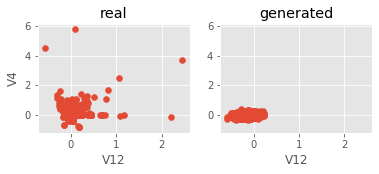

Step: 100 of 501.
Losses: G, D Gen, D Real, Xgb: 0.7266, 0.6915, 0.5748, 0.9714
D Real - D Gen: -0.1167


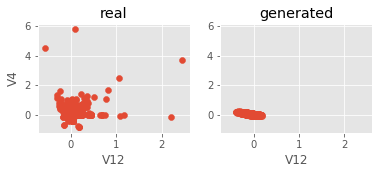

Step: 200 of 501.
Losses: G, D Gen, D Real, Xgb: 0.8179, 0.6667, 0.5950, 0.9787
D Real - D Gen: -0.0717


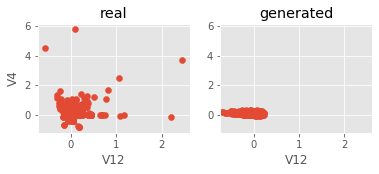

Step: 300 of 501.
Losses: G, D Gen, D Real, Xgb: 1.1606, 0.4686, 0.4934, 0.9751
D Real - D Gen: 0.0248


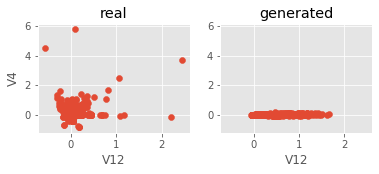

Step: 400 of 501.
Losses: G, D Gen, D Real, Xgb: 1.0323, 0.5304, 0.5275, 0.9678
D Real - D Gen: -0.0029


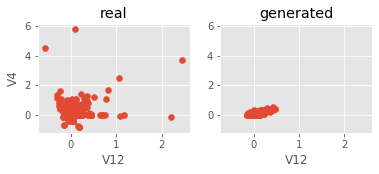

Step: 500 of 501.
Losses: G, D Gen, D Real, Xgb: 1.0301, 0.5406, 0.6378, 0.9639
D Real - D Gen: 0.0972


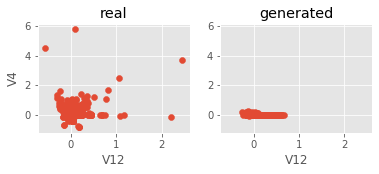

data_dim:  15
data_cols:  ['V12', 'V4', 'V2', 'V0', 'V8', 'V1', 'V10', 'V6', 'V13', 'V3', 'V9', 'V14', 'V7', 'V5', 'V11']
label_dim:  1
label_cols:  ['Class']
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_121 (InputLayer)           (None, 15)            0                                            
____________________________________________________________________________________________________
input_122 (InputLayer)           (None, 1)             0                                            
____________________________________________________________________________________________________
concatenate_37 (Concatenate)     (None, 16)            0           input_121[0][0]                  
                                                                   input_122[0][0]                  
_________________________________

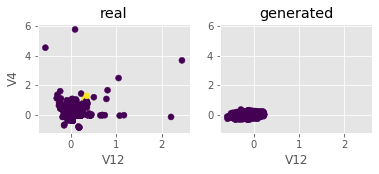

Step: 100 of 501.
Losses: G, D Gen, D Real, Xgb: 0.7199, 0.6976, 0.5853, 0.9678
D Real - D Gen: -0.1122


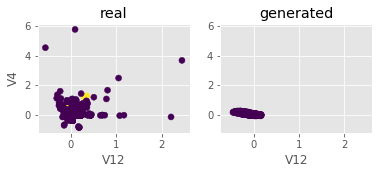

Step: 200 of 501.
Losses: G, D Gen, D Real, Xgb: 0.8032, 0.6618, 0.6195, 0.9843
D Real - D Gen: -0.0423


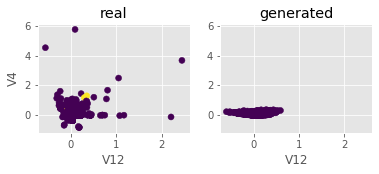

Step: 300 of 501.
Losses: G, D Gen, D Real, Xgb: 0.9660, 0.5748, 0.5851, 0.9703
D Real - D Gen: 0.0103


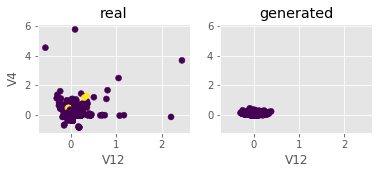

Step: 400 of 501.
Losses: G, D Gen, D Real, Xgb: 1.0292, 0.5415, 0.5751, 0.9813
D Real - D Gen: 0.0337


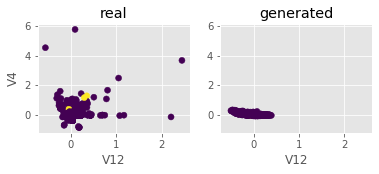

Step: 500 of 501.
Losses: G, D Gen, D Real, Xgb: 1.0036, 0.5721, 0.6567, 0.9672
D Real - D Gen: 0.0846


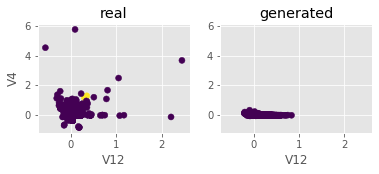

In [166]:
adversarial_training_GAN(arguments, train_no_label, data_cols ) # GAN

adversarial_training_GAN(arguments, train, data_cols=data_cols, label_cols=label_cols ) # CGAN

In [ ]:
%%time

# Training the WGAN and WCGAN architectures

k_d = 1 # train critic to optimal state each time
learning_rate = 5e-4#1e-4 # 5e-5
arguments = [rand_dim, nb_steps, batch_size, 
             k_d, k_g, critic_pre_train_steps, log_interval, learning_rate, base_n_count,
            data_dir, generator_model_path, discriminator_model_path, loss_pickle_path, show ]

adversarial_training_WGAN(arguments, train_no_label, data_cols=data_cols ) # WGAN
adversarial_training_WGAN(arguments, train, data_cols=data_cols, label_cols=label_cols ) # WCGAN

In [122]:
# # %%time

# # for continued training

# import GAN_171103
# import importlib
# importlib.reload(GAN_171103) # For reloading after making changes
# from GAN_171103 import *

# prefix_list = ['GAN', 'CGAN','WGAN','WCGAN']

# for prefix in prefix_list:
#     last_step = 10000
#     #data_dir = 'cache lr mix base 128 act mix 171026/'
#     data_dir = 'cache/'

#     # Choose your learning rate
#     # learning_rate = 1e-5 # first 10k
#     # learning_rate = 1e-5 # 10-15k
#     # learning_rate = 1e-6 # 15-20k

#     generator_model_path = data_dir + prefix + '_generator_model_weights_step_' + str(last_step) + '.h5'
#     discriminator_model_path = data_dir + prefix + '_discriminator_model_weights_step_' + str(last_step) + '.h5'
#     loss_pickle_path = data_dir + prefix + '_losses_step_' + str(last_step) + '.pkl'

#     nb_steps = 4000

#     arguments = [rand_dim, nb_steps, batch_size, 
#                  k_d, k_g, critic_pre_train_steps, log_interval, learning_rate, base_n_count,
#                 data_dir, generator_model_path, discriminator_model_path, loss_pickle_path, show ]
#     # Choose your training algorithm
#     if prefix == 'GAN':
#         adversarial_training_GAN(arguments, train_no_label, data_cols=data_cols, starting_step=last_step+1 ) # GAN
#         break
#     elif prefix == 'CGAN':
#         adversarial_training_GAN(arguments, train, data_cols=data_cols, label_cols=label_cols, starting_step=last_step+1 ) # CGAN
#     elif prefix == 'WGAN':
#         adversarial_training_WGAN(arguments, train_no_label, data_cols=data_cols, starting_step=last_step+1 ) # WGAN
#     elif prefix == 'WCGAN':
#         adversarial_training_WGAN(arguments, train, data_cols=data_cols, label_cols=label_cols, starting_step=last_step+1 ) # WCGAN

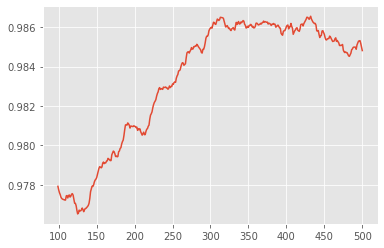

In [82]:

# For reloading loss data from pickles

prefix = 'GAN'
step = 5000

[combined_loss, disc_loss_generated, disc_loss_real, xgb_losses] = pickle.load(
    open(data_dir+prefix+'_losses_step_'+str(step)+'.pkl','rb'))


# plt.plot( xgb_losses[:] ) ;
w = 100
plt.plot( pd.DataFrame(xgb_losses[:]).rolling(w).mean() ) ;

In [83]:

# Look for the step with the lowest xgboost accuracy, and the lowest step saved (every 100)

best_step = list(xgb_losses).index( xgb_losses.min() ) * 10
print( best_step, xgb_losses.min() )

xgb100 = [ xgb_losses[i] for i in range(0, len(xgb_losses), 10) ]
best_step = xgb100.index( min(xgb100) ) * log_interval
print( best_step, min(xgb100) )

580 0.9522
7000 0.9532


In [84]:

# Look for the step with the lowest critic loss, and the lowest step saved (every 100)

delta_losses = np.array(disc_loss_real) - np.array(disc_loss_generated)

best_step = list(delta_losses).index( delta_losses.min() )
print( best_step, delta_losses.min() )

delta100 = [ delta_losses[i] for i in range(0, len(delta_losses), 100) ]
best_step = delta100.index( min(delta100) ) * log_interval
print( best_step, min(delta100) )

1371 -0.35047254
1000 -0.10603547


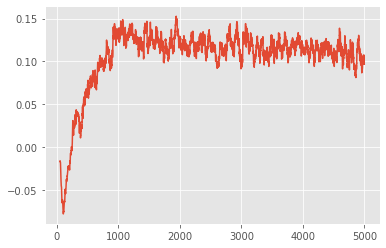

In [85]:
# plt.plot( (np.array(disc_loss_real) - np.array(disc_loss_generated)) )

w = 50
# plt.plot( list(range(0,5001,1)), pd.rolling_mean((np.array(disc_loss_real) - np.array(disc_loss_generated)),w) )
plt.plot( pd.DataFrame(disc_loss_real[:]).rolling(w).mean() - pd.DataFrame(disc_loss_generated[:]).rolling(w).mean() ) ;

# plt.xlim([9000,10000])
# plt.ylim([0.03,0.05])

In [87]:
# Let's look at some of the generated data
# First create the networks locally and load the weights

import GAN_171103
import importlib
importlib.reload(GAN_171103) # For reloading after making changes
from GAN_171103 import *

seed = 18

train = fraud_w_classes.copy().reset_index(drop=True) # fraud only with labels from classification

# train = pd.get_dummies(train, columns=['Class'], prefix='Class', drop_first=True)
label_cols = [ i for i in train.columns if 'Class' in i ]
data_cols = [ i for i in train.columns if i not in label_cols ]
train[ data_cols ] = train[ data_cols ] / 10 # scale to random noise size, one less thing to learn
train_no_label = train[ data_cols ]

data_dim = len(data_cols)
label_dim = len(label_cols)
with_class = False
if label_dim > 0: with_class = True
np.random.seed(seed)

# define network models

# generator_model, discriminator_model, combined_model = define_models_CGAN(rand_dim, data_dim, label_dim, base_n_count, type='Wasserstein')
# generator_model.load_weights('cache/WCGAN_generator_model_weights_step_4800.h5')
generator_model, discriminator_model, combined_model = define_models_CGAN(rand_dim, data_dim, label_dim, base_n_count)
generator_model.load_weights('cache/CGAN_generator_model_weights_step_5000.h5')


# with_class = False
# train = train_no_label
# label_cols = []
# # generator_model, discriminator_model, combined_model = define_models_GAN(rand_dim, data_dim, base_n_count, type='Wasserstein')
# # generator_model.load_weights('cache/WGAN_generator_model_weights_step_4800.h5')

# generator_model, discriminator_model, combined_model = define_models_GAN(rand_dim, data_dim, base_n_count)
# generator_model.load_weights('cache/GAN_generator_model_weights_step_5000.h5')


# Now generate some new data

test_size = SILKROAD_TX_NUM # Equal to all of the fraud cases

x = get_data_batch(train, test_size, seed=17)#i+j) i,j가 무엇을 의미?
z = np.random.normal(size=(test_size, rand_dim))
print(z)
if with_class:
    labels = x[:,-label_dim:]
    g_z = generator_model.predict([z, labels])
else:
    g_z = generator_model.predict(z)

[[ 0.23268013 -0.47510866 -2.09564338 ...  1.45900266 -0.13472523
   0.63866683]
 [-1.00658175 -0.02670457 -0.5085759  ... -2.0933977  -0.13437578
  -0.62167348]
 [-1.23704888 -1.05907982 -0.24030074 ...  1.54970475  0.64960418
  -0.49708076]
 ...
 [ 1.21501506 -0.47338659 -1.17494655 ... -0.47014249 -1.23671576
   0.66493044]
 [ 2.35439518 -0.27127731  0.35973641 ...  0.85856696  1.85906644
  -0.25206086]
 [-1.86935394 -1.61163467 -2.37612204 ... -1.52752047  1.49039657
   1.13660289]]


0.9939


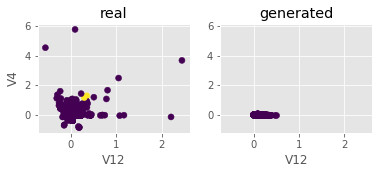

In [88]:
# Check using the same functions used during GAN training

print( CheckAccuracy( x, g_z, data_cols, label_cols, seed=0, with_class=with_class, data_dim=data_dim ) )

PlotData( x, g_z, data_cols, label_cols, seed=0, with_class=with_class, data_dim=data_dim )

In [89]:
# Now we can train and test an xgboost classifier on our generated data

real_samples = pd.DataFrame(x, columns=data_cols+label_cols)
test_samples = pd.DataFrame(g_z, columns=data_cols+label_cols)
real_samples['syn_label'] = 0
test_samples['syn_label'] = 1

training_fraction = 0.5
n_real, n_test = int(len(real_samples)*training_fraction), int(len(test_samples)*training_fraction)
train_df = pd.concat([real_samples[:n_real],test_samples[:n_test]],axis=0)
test_df = pd.concat([real_samples[n_real:],test_samples[n_test:]],axis=0)

# X_col = test_df.columns[:-(label_dim+1)]
X_col = test_df.columns[:-1]
y_col = test_df.columns[-1]
dtrain = xgb.DMatrix(train_df[X_col], train_df[y_col], feature_names=X_col)
dtest = xgb.DMatrix(test_df[X_col], feature_names=X_col)
y_true = test_df['syn_label']

# dtrain = np.vstack( [ x[:int(len(x)/2)], g_z[:int(len(g_z)/2)] ] )
# dlabels = np.hstack( [ np.zeros(int(len(x)/2)), np.ones(int(len(g_z)/2)) ] )
# dtest = np.vstack( [ x[int(len(x)/2):], g_z[int(len(g_z)/2):] ] )

# dtrain = xgb.DMatrix(dtrain, dlabels, feature_names=data_cols+label_cols)
# dtest = xgb.DMatrix(dtest, feature_names=data_cols+label_cols)
# y_true = dlabels

xgb_params = {
    'max_depth': 4,
    'objective': 'binary:logistic',
    'random_state': 0,
    'eval_metric': 'auc', # allows for balanced or unbalanced classes 
}
xgb_test = xgb.train(xgb_params, dtrain, num_boost_round=10)

y_pred = np.round(xgb_test.predict(dtest))

print( '{:.2f}'.format(SimpleAccuracy(y_pred, y_true)) )

0.99


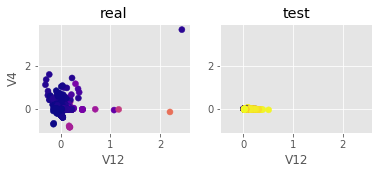

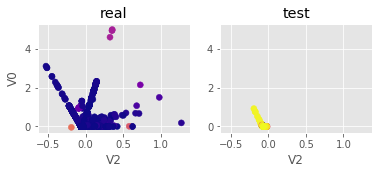

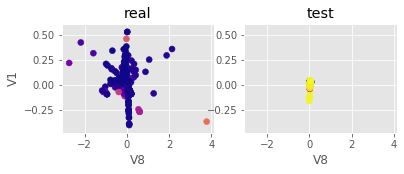

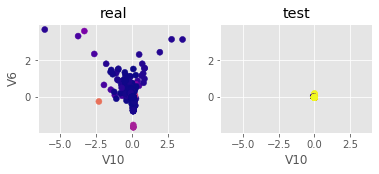

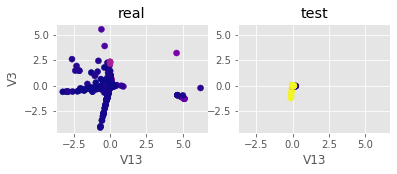

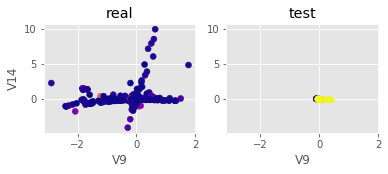

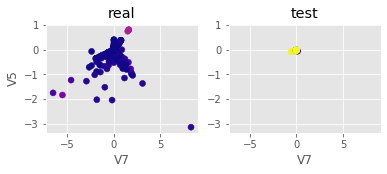

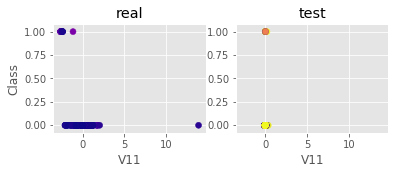

In [90]:

# Let's look at how the discrimnator scored real and generated data, visualized along every feature

y_pred0 = xgb_test.predict(dtest)

for i in range(0,len(X_col)-1, 2):

    f, axarr = plt.subplots(1, 2, figsize=(6,2) )

    axarr[0].scatter( test_df[:n_real][X_col[i]], test_df[:n_real][X_col[i+1]], c=y_pred0[:n_real], cmap='plasma'  )
    axarr[0].set_title('real')
    axarr[0].set_ylabel(X_col[i+1])

    axarr[1].scatter( test_df[n_real:][X_col[i]], test_df[n_real:][X_col[i+1]], c=y_pred0[n_real:], cmap='plasma'  )
    axarr[1].set_title('test')
    axarr[1].set_xlim(axarr[0].get_xlim()), axarr[1].set_ylim(axarr[0].get_ylim())

    for a in axarr:
        a.set_xlabel(X_col[i])

    plt.show()

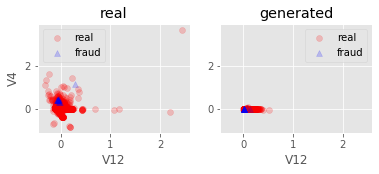

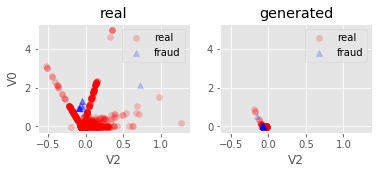

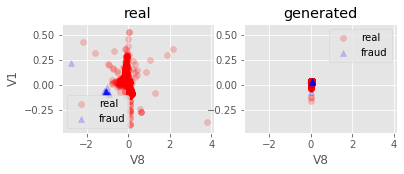

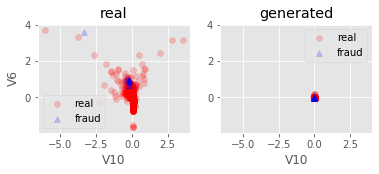

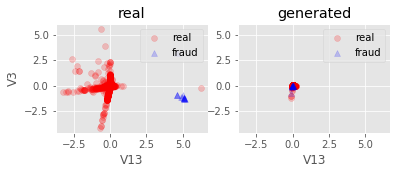

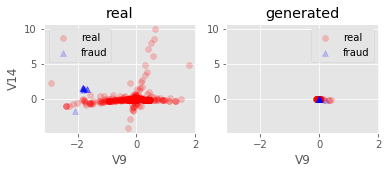

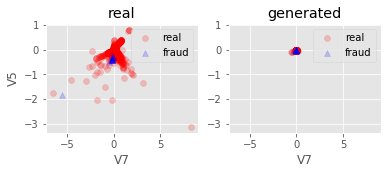

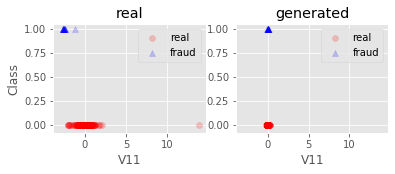

In [91]:

# Now we can compare the real and generated data by class, along every feature

colors = ['red','blue']
markers = ['o','^']
labels = ['real','fraud']

class_label = 'Class'

for i in range(0,len(X_col), 2):
    col1, col2 = i, i+1
    if i+1 >= len(X_col): continue
    
    f, axarr = plt.subplots(1, 2, figsize=(6,2) )
    for group, color, marker, label in zip( test_df[:n_real].groupby(class_label), colors, markers, labels ):
        axarr[0].scatter( group[1][X_col[col1]], group[1][X_col[col2]], label=label, c=color, marker=marker, alpha=0.2) 
    axarr[0].legend()
    axarr[0].set_title('real')
    axarr[0].set_ylabel(X_col[col2])

    for group, color, marker, label in zip( test_df[n_real:].groupby(class_label), colors, markers, labels ):
        axarr[1].scatter( group[1][X_col[col1]], group[1][X_col[col2]], label=label, c=color, marker=marker, alpha=0.2) 
    axarr[1].set_xlim(axarr[0].get_xlim()), axarr[1].set_ylim(axarr[0].get_ylim())
    axarr[1].legend()
    axarr[1].set_title('generated') ;

    for a in axarr:
        a.set_xlabel(X_col[col1])

    plt.show()

In [92]:

# Evaluate performance on validation set

SimpleMetrics(y_pred,y_true)

Confusion Matrix


,Pred 0,Pred 1
True 0,4980,20
True 1,41,4959


Accuracy : 0.9939


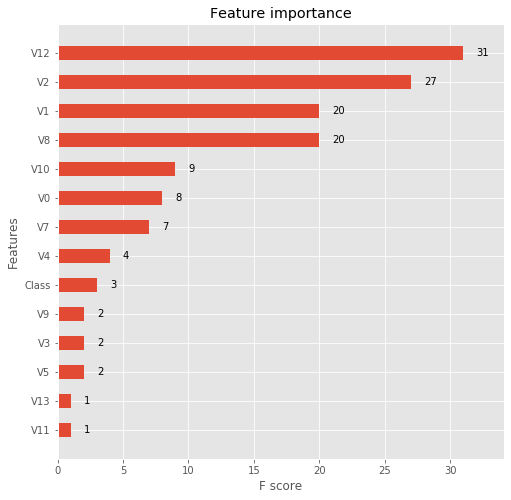

In [93]:

# Plot feature importances used for identifying generated data

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
xgb.plot_importance(xgb_test, max_num_features=20, height=0.5, ax=ax);

<a id="Compare GAN Output"><h1>Compare GAN Output</h1></a>

<a href='#TOC'>Table of contents</a>
<br><br>



It may be best to restart the notebook, run the setup section, and then run this section


In [9]:

# Set up the training dataset

train = fraud_w_classes.copy().reset_index(drop=True) # fraud only with labels from classification

train = pd.get_dummies(train, columns=['Class'], prefix='Class', drop_first=True)
label_cols = [ i for i in train.columns if 'Class' in i ]
data_cols = [ i for i in train.columns if i not in label_cols ]
train[ data_cols ] = train[ data_cols ] / 10 # scale to random noise size, one less thing to learn
train_no_label = train[ data_cols ]

data_dim = len(data_cols)
label_dim = len(label_cols)

# Generate empty models

rand_dim = 15
base_n_count = 128
model_names = ['GAN','CGAN','WGAN','WCGAN']
with_classes = [False, True, False, True]
type0s = [None, None, 'Wasserstein', 'Wasserstein']

models = {}

for model_name, with_class, type0 in zip(model_names, with_classes, type0s ):

    if with_class:
        generator_model, discriminator_model, combined_model = \
            define_models_CGAN(rand_dim, data_dim, label_dim, base_n_count, type=type0)
    else:
         generator_model, discriminator_model, combined_model = \
            define_models_GAN(rand_dim, data_dim, base_n_count, type=type0)   
    
    models[model_name] = [ model_name, with_class, type0, generator_model ]


# Setup parameters

seed = 17
test_size =  SILKROAD_TX_NUM# number of fraud cases

np.random.seed(seed)
z = np.random.normal(size=(test_size, rand_dim))
x = get_data_batch(train, test_size, seed=seed)
real_samples = pd.DataFrame(x, columns=data_cols+label_cols)
labels = x[:,-label_dim:]

# colors = ['C1','C9']
# colors = ['xkcd:plum', 'xkcd:navy']
colors = ['red','blue']
markers = ['o','^']
class_labels = ['Class 1','Class 2']

col1, col2 = 'V12', 'V2' #'V17', 'V10'
#['tx_fee_trns_avg', 'txsize_trns_avg', 'sib_input_out_avg', 'sibaddr_trns_avg', 'trns_value_min', 'trns_value_sum', 'btc_trns_min', 'trns_value_avg', 'sib_input_avg', 'tx_fee_recv_avg', 'btc_trns_sum', 'rel_tx_trns_cnt', 'btc_trns_avg', 'trns_value_max', 'txsize_recv_avg', 'sib_output_avg', 'btc_recv_min', 'btc_trns_max', 'recv_value_min', 'btc_recv_sum', 'recv_value_sum', 'btc_recv_avg', 'sibaddr_trns_out_avg', 'recv_value_avg', 'recv_value_max', 'sibaddr_recv_in_avg', 'sibaddr_recv_avg', 'rel_tx_recv_cnt', 'sib_output_in_avg', 'btc_recv_max']
base_dir = 'cache/'# lr mix base 128 act mix 171026/'


Instructions for updating:
Colocations handled automatically by placer.


<a id="Fig5"><h1>Figure 5: Comparison of GAN outputs</h1></a><br>
<a href='#TOC'>Table of contents</a>

0
500
1000
2000


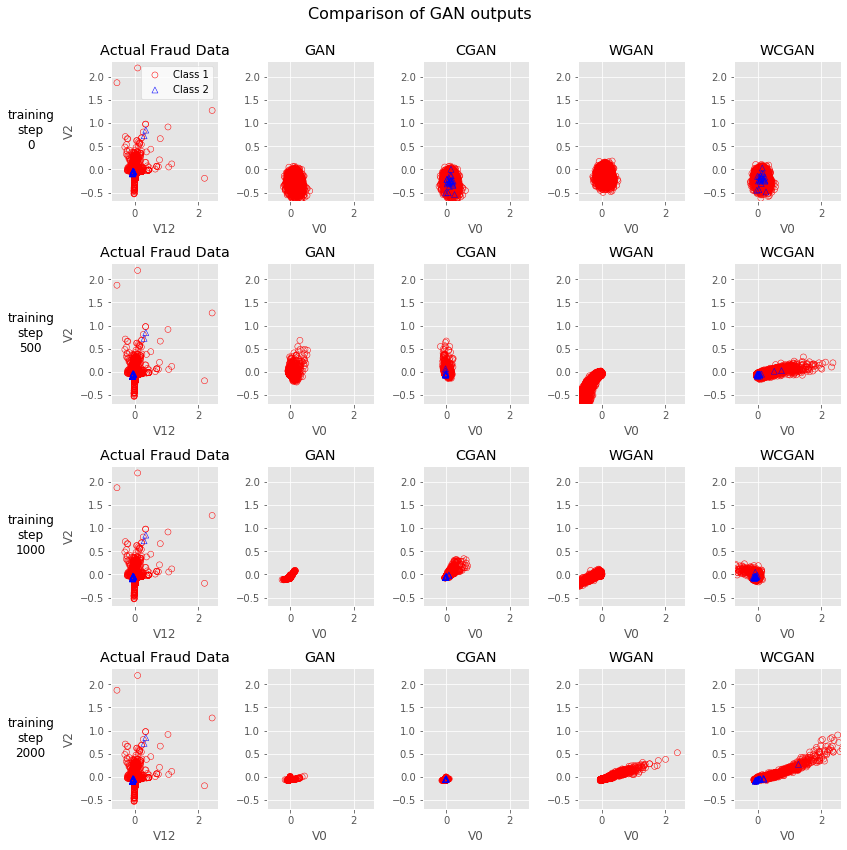

In [11]:


# model_steps = [500, 5000]
# model_steps = [ 0, 100, 200, 500, 1000 ]
model_steps = [ 0, 500, 1000,2000 ]#, 6000, 8000, 10000]
rows = len(model_steps)
columns = 5

axarr = [[]]*len(model_steps)

fig = plt.figure(figsize=(12,rows*3))

for model_step_ix, model_step in enumerate( model_steps ):
    print(model_step)
        
    axarr[model_step_ix] = plt.subplot(rows, columns, model_step_ix*columns + 1)
    
    for group, color, marker, label in zip( real_samples.groupby('Class_1'), colors, markers, class_labels ):
        plt.scatter( group[1][[col1]], group[1][[col2]], 
                         label=label, marker=marker, edgecolors=color, facecolors='none' )
    
    plt.title('Actual Fraud Data')
    plt.ylabel(col2) # Only add y label to left plot
    plt.xlabel(col1)
    xlims, ylims = axarr[model_step_ix].get_xlim(), axarr[model_step_ix].get_ylim() #plt.xlim(-2,2),plt.ylim(-2,2)#
    #print("limit:",ylims)
    
    if model_step_ix == 0: 
        legend = plt.legend()
        legend.get_frame().set_facecolor('white')
    
    for i, model_name in enumerate( model_names[:] ):
        
        [ model_name, with_class, type0, generator_model ] = models[model_name]
        
        generator_model.load_weights( base_dir + model_name + '_generator_model_weights_step_'+str(model_step)+'.h5')

        ax = plt.subplot(rows, columns, model_step_ix*columns + 1 + (i+1) )
        
        if with_class:
            g_z = generator_model.predict([z, labels])
            gen_samples = pd.DataFrame(g_z, columns=data_cols+label_cols)
            for group, color, marker, label in zip( gen_samples.groupby('Class_1'), colors, markers, class_labels ):
                plt.scatter( group[1][[col1]], group[1][[col2]], 
                                 label=label, marker=marker, edgecolors=color, facecolors='none' )
        else:
            g_z = generator_model.predict(z)
            gen_samples = pd.DataFrame(g_z, columns=data_cols)
            plt.scatter( gen_samples[[col1]], gen_samples[[col2]], 
                             label=class_labels[0], marker=markers[0], edgecolors=colors[0], facecolors='none' )
        plt.title(model_name)   
        plt.xlabel(data_cols[0])
        ax.set_xlim(xlims), ax.set_ylim(ylims)


plt.suptitle('Comparison of GAN outputs', size=16)
plt.tight_layout(rect=[0.075,0,1,0.95])

# Adding text labels for traning steps
vpositions = np.array([ i._position.bounds[1] for i in axarr ])
vpositions += ((vpositions[0] - vpositions[1]) * 0.35 )
for model_step_ix, model_step in enumerate( model_steps ):
    fig.text( 0.05, vpositions[model_step_ix], 'training\nstep\n'+str(model_step), ha='center', va='center', size=12)

plt.savefig('plots/Comparison_of_GAN_outputs.png')

<a id="Generated Data Testing"><h1>Generated Data Testing</h1></a>

<a href='#TOC'>Table of contents</a>

In [13]:

# Setup xgboost parameters

xgb_params = {
#     'max_depth': 4,
    'objective': 'binary:logistic',
    'random_state': 0,
    'eval_metric': 'auc', # auc, error
#     'tree_method': 'hist'
#     'grow_policy': 'lossguide' # depthwise, lossguide
}

# https://github.com/dmlc/xgboost/blob/master/demo/guide-python/custom_objective.py

from sklearn.metrics import recall_score, precision_score, roc_auc_score,f1_score

def recall(preds, dtrain):
    labels = dtrain.get_label()
    return 'recall',  recall_score(labels, np.round(preds))

def precision(preds, dtrain):
    labels = dtrain.get_label()
    return 'precision',  precision_score(labels, np.round(preds))

def roc_auc(preds, dtrain):
    labels = dtrain.get_label()
    return 'roc_auc',  roc_auc_score(labels, preds)

def F1(preds, dtrain):
    labels = dtrain.get_label()
    return 'f1',  f1_score(labels, preds) 

# Define model parameters

seed = 17
np.random.seed(seed)

data_dim = len(data_cols)
label_dim = len(label_cols)

base_dir = 'cache/'

base_n_count = 128



# defined training set parameters

train_fraction = 0.7
X_col = data.columns[:-1]
y_col = data.columns[-1]

folds = 5



# Function to make cross folds with different amounts of an additional dataset added

def MakeCrossFolds( g_z_df=[] ):

    np.random.seed(0)

    train_real_set, test_real_set = [], []
    train_fraud_set, test_fraud_set = [], []

    real_samples = data.loc[ data.Class==0 ].copy()
    fraud_samples = data.loc[ data.Class==1 ].copy()

#     n_temp_real = 10000 
    n_temp_real = len(real_samples)

    for seed in range(folds):
        np.random.seed(seed)

        fraud_samples = fraud_samples.sample(len(fraud_samples), replace=False).reset_index(drop=True) # shuffle

    #     n_train_fraud = int(len(fraud_samples) * train_fraction)
        n_train_fraud = 100
        train_fraud_samples = fraud_samples[:n_train_fraud].reset_index(drop=True)

    #     test_fraud_samples = fraud_samples[n_train_fraud:].reset_index(drop=True)
        n_test_fraud = SILKROAD_TX_NUM//3 # 30% left out
        test_fraud_samples = fraud_samples[-n_test_fraud:].reset_index(drop=True)

        if len(g_z_df)==0: g_z_df = fraud_samples[n_train_fraud:-n_test_fraud] # for adding real data, if no generated
        n_g_z = len(g_z_df)
        train_fraud_samples = train_fraud_samples.append(g_z_df).reset_index(drop=True)

        real_samples = real_samples.sample(len(real_samples), replace=False).reset_index(drop=True) # shuffle
        temp_real_samples = real_samples[:n_temp_real]
        n_train_real = int(len(temp_real_samples) * train_fraction)

        train_real_samples = temp_real_samples[:n_train_real].reset_index(drop=True) # with margin
        test_real_samples = temp_real_samples[n_train_real:].reset_index(drop=True) # with margin

        train_real_set.append( train_real_samples )
        test_real_set.append( test_real_samples )
        train_fraud_set.append( train_fraud_samples )
        test_fraud_set.append( test_fraud_samples )

    #print( n_train_fraud )
    #for i in [ fraud_samples, g_z_df, train_fraud_samples, test_fraud_samples ]: print( len(i) )
    #for i in [ real_samples, train_real_samples, test_real_samples ]: print( len(i) )
    # [ [ len(i) for i in j ] for j in [train_real_set, test_real_set, train_fraud_set, test_fraud_set] ]
    print("CrossFold finished!!")
    return n_train_fraud, train_real_set, test_real_set, train_fraud_set, test_fraud_set



# function to run an xgboost classifier on different cross-folds with different amounts of data added

def Run_CV_Xgb(n_train_fraud, train_real_set, test_real_set, train_fraud_set, test_fraud_set):

    test_data=[]

    # for i in [1]:
    # for i in [1,2,5,10,20]:
    # for i in np.logspace(0,np.log10(11),num=5):
    # for i in np.logspace(0,np.log10(11),num=3):
    for i in np.logspace(0,np.log10(((test_size*7)/10)/100),num=5):

        print('# additional generated data tested: {}'.format (int(n_train_fraud*(i-1)) ) )
        for k in range(folds):

            train_df = pd.concat( 
                [ train_real_set[k], train_fraud_set[k][:int(n_train_fraud*i)] ],
                 axis=0,ignore_index=True).reset_index(drop=True)

            test_df = pd.concat( 
                [ test_real_set[k], test_fraud_set[k] ],
                axis=0,ignore_index=True).reset_index(drop=True)

            dtrain = xgb.DMatrix(train_df[X_col], train_df[y_col], feature_names=X_col)
            dtest = xgb.DMatrix(test_df[X_col], test_df[y_col], feature_names=X_col)

            results_dict = {}
            xgb_test = xgb.train(xgb_params, dtrain, num_boost_round=100, 
                                 verbose_eval=False, early_stopping_rounds=10, 
                                 evals=[(dtrain,'train'),(dtest,'test')],
                                 evals_result = results_dict )

            y_pred = xgb_test.predict(dtest, ntree_limit=xgb_test.best_iteration+1)
            y_true = test_df['Class'].values
            results = [k, i, xgb_test.best_iteration, recall( y_pred, dtest )[1], precision( y_pred, dtest )[1], roc_auc( y_pred, dtest )[1] ]
    #         print(results)

            test_data.append(results)
    test_data = pd.DataFrame(test_data, columns=['k', 'ratio','best','recall','precision','auc'])
    ###
    print( 'best iteration: ', xgb_test.best_iteration )
    print(recall( y_pred, dtest ))
    print(precision( y_pred, dtest ) )
    print( roc_auc( y_pred, dtest ) )
    #print(F1( y_pred, dtest ))
    # print( 'Accuracy: {:.3f}'.format(SimpleAccuracy(y_pred, y_true)) )
    SimpleMetrics( np.round(y_pred), y_true)
    ###
    
    return test_data


test_size =  SILKROAD_TX_NUM

In [14]:
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE

x = get_data_batch(fraud_w_classes, test_size, seed=0)
y = []
tmp=0
for i in range(test_size):
    if x[i][15] == 1 :
        y.append(1)
    else:
        y.append(0)


# 모델설정
sm = SMOTE(random_state=42)

# train데이터를 넣어 복제함
X_re, Y_re = sm.fit_sample(x,y)

g_z = pd.DataFrame(X_re, columns=data.columns)
g_z_df = g_z.loc[g_z.Class == 1].copy()
#print(g_z_df)
n_train_fraud, train_real_set, test_real_set, train_fraud_set, test_fraud_set = MakeCrossFolds(g_z_df)
t_SMOTE = Run_CV_Xgb(n_train_fraud, train_real_set, test_real_set, train_fraud_set, test_fraud_set)

CrossFold finished!!
# additional generated data tested: 0
# additional generated data tested: 189
# additional generated data tested: 736
# additional generated data tested: 2320
# additional generated data tested: 6900
best iteration:  52
('recall', 0.2919291929192919)
('precision', 0.9989733059548255)
('roc_auc', 0.9848126162616262)
Confusion Matrix


,Pred 0,Pred 1
True 0,29999,1
True 1,2360,973


Accuracy : 0.929169291692917


In [17]:
%%time

# Generate and test data with untrained model
rand_dim = 15
MODEL_NAME = 'WCGAN'
STEP = 0
FILE_NAME = MODEL_NAME + '_generator_model_weights_step_' + str(STEP) +'.h5'
generator_model, discriminator_model, combined_model = define_models_CGAN(rand_dim, data_dim, label_dim, base_n_count, type='Wasserstein')
generator_model.load_weights( base_dir + FILE_NAME)

test_size = SILKROAD_TX_NUM
x = get_data_batch(fraud_w_classes, test_size, seed=0)
z = np.random.normal(size=(test_size, rand_dim))
labels = x[:,-label_dim:]

g_z = generator_model.predict([z, labels])

# The labels for the generate data will all be 1, as they are supposed to be fraud data
g_z_df = pd.DataFrame( np.hstack( [g_z[:,:len(data_cols)], np.ones((len(g_z),1))] ), columns=data.columns )

n_train_fraud, train_real_set, test_real_set, train_fraud_set, test_fraud_set = MakeCrossFolds(g_z_df)




t_0 = Run_CV_Xgb(n_train_fraud, train_real_set, test_real_set, train_fraud_set, test_fraud_set)

CrossFold finished!!
# additional generated data tested: 0
# additional generated data tested: 189
# additional generated data tested: 736
# additional generated data tested: 2320
# additional generated data tested: 6900
best iteration:  42
('recall', 0.2826282628262826)
('precision', 1.0)
('roc_auc', 0.9833619861986198)
Confusion Matrix


,Pred 0,Pred 1
True 0,30000,0
True 1,2391,942


Accuracy : 0.9282692826928269
CPU times: user 3min 58s, sys: 2.43 s, total: 4min 1s
Wall time: 4min 9s


In [24]:
%%time

# Generate and test data with trained model
STEP = 5000
FILE_NAME = MODEL_NAME + '_generator_model_weights_step_' + str(STEP) +'.h5' 
generator_model, discriminator_model, combined_model = define_models_CGAN(rand_dim, data_dim, label_dim, base_n_count, type='Wasserstein')
generator_model.load_weights( base_dir + FILE_NAME)

test_size = SILKROAD_TX_NUM
x = get_data_batch(fraud_w_classes, test_size, seed=0)
z = np.random.normal(size=(test_size, rand_dim))
labels = x[:,-label_dim:]
g_z = generator_model.predict([z, labels])



# The labels for the generate data will all be 1, as they are supposed to be fraud data
g_z_df = pd.DataFrame( np.hstack( [g_z[:,:len(data_cols)], np.ones((len(g_z),1))] ), columns=data.columns )

n_train_fraud, train_real_set, test_real_set, train_fraud_set, test_fraud_set = MakeCrossFolds(g_z_df)


    
t_4800 = Run_CV_Xgb(n_train_fraud, train_real_set, test_real_set, train_fraud_set, test_fraud_set)

CrossFold finished!!
# additional generated data tested: 0
# additional generated data tested: 189
# additional generated data tested: 736
# additional generated data tested: 2320
# additional generated data tested: 6900
best iteration:  54
('recall', 0.2808280828082808)
('precision', 0.997867803837953)
('roc_auc', 0.9843060256025603)
Confusion Matrix


,Pred 0,Pred 1
True 0,29998,2
True 1,2397,936


Accuracy : 0.928029280292803
CPU times: user 4min 19s, sys: 1.66 s, total: 4min 21s
Wall time: 4min 23s


In [23]:
# Generate and test data with additional real data

n_train_fraud, train_real_set, test_real_set, train_fraud_set, test_fraud_set = MakeCrossFolds()
    
t_real = Run_CV_Xgb(n_train_fraud, train_real_set, test_real_set, train_fraud_set, test_fraud_set)

CrossFold finished!!
# additional generated data tested: 0
# additional generated data tested: 189
# additional generated data tested: 736
# additional generated data tested: 2320
# additional generated data tested: 6900
best iteration:  92
('recall', 0.9774977497749775)
('precision', 0.9693543588217792)
('roc_auc', 0.999360901090109)
Confusion Matrix


,Pred 0,Pred 1
True 0,29897,103
True 1,75,3258


Accuracy : 0.994659946599466


In [25]:
# Save the testing data

# Run using the WCGAN trained after 0 steps

pickle.dump( t_SMOTE, open('cache/additional SMOTE generated fraud data test.pkl','wb'))

pickle.dump( t_0, open('cache/additional untrained generated fraud data test.pkl','wb'))

# Run using the WCGAN trained after 4800 steps
pickle.dump( t_4800, open('cache/additional generated fraud data test.pkl','wb'))

# Run using the real data
pickle.dump( t_real, open('cache/additional real fraud data test.pkl','wb'))

In [ ]:
# Reload the testing data
t_SMOTE = pickle.load(open('cache/additional SMOTE generated fraud data test.pkl','rb'))

t_0 = pickle.load(open('cache/additional untrained generated fraud data test.pkl','rb'))
t_4800 = pickle.load(open('cache/additional generated fraud data test.pkl','rb'))
t_real = pickle.load(open('cache/additional real fraud data test.pkl','rb'))

<a id="Fig8"><h1>Figure 8: Effects of Additional Data on Fraud Detection</h1></a><br>

<a href='#TOC'>Table of contents</a>

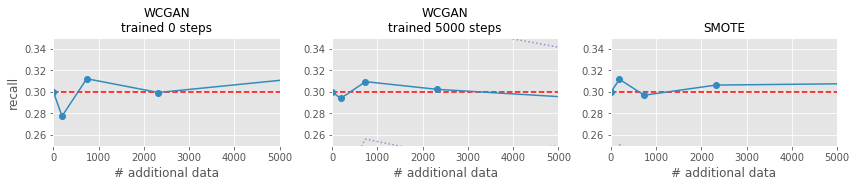

In [36]:

# Plot the testing data

labels = ['WCGAN\ntrained 0 steps','WCGAN\ntrained 5000 steps','SMOTE']

metric = 'recall'
#metrics = ['recall','precision','auc','k'd,ratio,best]
plt.figure(figsize=(12,3))
#for metric in metrics:
for i, [label, test_data] in enumerate(zip(labels, [t_0, t_4800, t_SMOTE])):
    xs = [ n_train_fraud * (i[0]-1) for i in test_data.groupby('ratio') ]
    ys = test_data.groupby('ratio')[metric].mean().values
    stds = 2 * test_data.groupby('ratio')[metric].std().values

    plt.subplot(1,3,i+1)
    plt.axhline(ys[0],linestyle='--',color='red')
    plt.plot(xs,ys,c='C1',marker='o')
    plt.plot(xs,ys+stds,linestyle=':',c='C2')
    plt.plot(xs,ys-stds,linestyle=':',c='C2')
    if i==0: plt.ylabel(metric)
    plt.xlabel('# additional data')
    plt.title(label,size=12)
    plt.xlim([0,5000])
#     plt.ylim([0.15,.995])
    plt.ylim([0.25,0.35])

plt.tight_layout(rect=[0,0,1,0.9])
#plt.suptitle('Effects of additional data on fraud detection', size=16)
plt.savefig('plots/Effects of addtional data on fraud detection.png')
plt.show()


<a id="Summary"><h1>Summary of Training Data</h1></a>

<a href='#TOC'>Table of contents</a>
<br><br>


In [158]:

# Load the saved loss data from each model

base_dir = 'cache/'

suffix = '_step_5000'

GAN_losses = pickle.load(open(base_dir + 'GAN_losses'+suffix+'.pkl','rb'))
# GAN_losses = [combined_loss, disc_loss_real, disc_loss_generated, xgb_losses]

CGAN_losses = pickle.load(open(base_dir + 'CGAN_losses'+suffix+'.pkl','rb'))
WGAN_losses = pickle.load(open(base_dir + 'WGAN_losses'+suffix+'.pkl','rb'))
WCGAN_losses = pickle.load(open(base_dir + 'WCGAN_losses'+suffix+'.pkl','rb'))


# Find best xgb scores overall and saved (every 100 steps)

data_ix = 3
data_sets = [ GAN_losses[data_ix], CGAN_losses[data_ix], WGAN_losses[data_ix], WCGAN_losses[data_ix]]
labels = [ 'GAN','CGAN','WGAN','WCGAN' ]

for label, data_set in zip( labels, data_sets ):
    best_step = list(data_set).index( np.array(data_set).min() ) * 10
    print( '{: <5} step {: <4}: {:.4f}'.format( label, best_step, np.array(data_set).min() ) )

    xgb100 = [ data_set[i] for i in range(0, len(data_set), 10) ]
    best_step = xgb100.index( min(xgb100) ) * 100
    print( '{: <5} step {: <4}: {:.4f}\n'.format( label, best_step, np.array(xgb100).min() ) )
#     print( best_step, min(xgb100) )

GAN   step 580 : 0.9522
GAN   step 700 : 0.9532

CGAN  step 1190: 0.9474
CGAN  step 600 : 0.9493

WGAN  step 130 : 0.9888
WGAN  step 300 : 0.9915

WCGAN step 50  : 0.9798
WCGAN step 2800: 0.9870



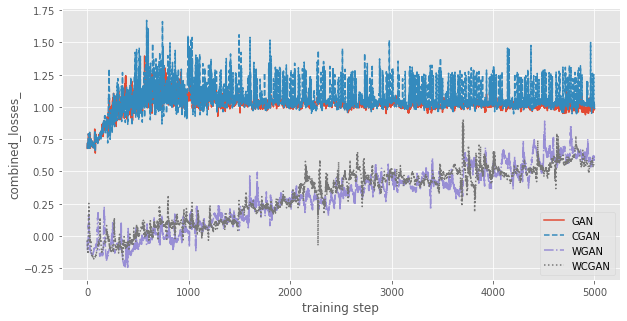

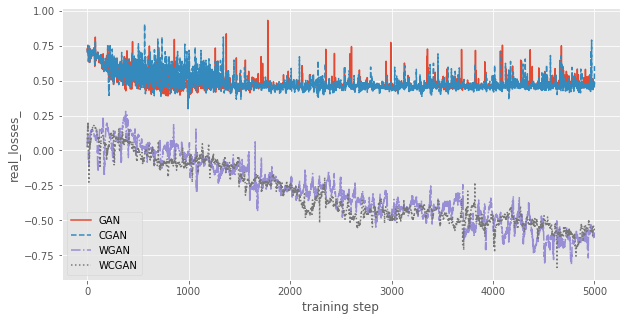

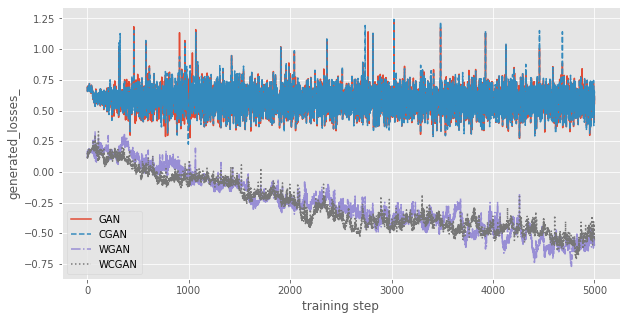

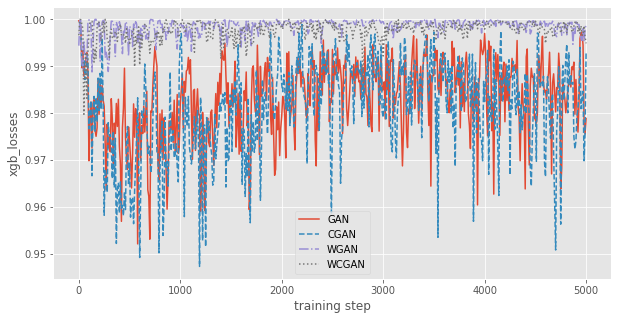

In [159]:

# Look at the unsmoothed losses

data_fields = ['combined_losses_', 'real_losses_', 'generated_losses_', 'xgb_losses']
sampling_intervals = [ 1, 1, 1, 10 ]
labels = [ 'GAN','CGAN','WGAN','WCGAN' ]
linestyles = ['-', '--', '-.', ':']

for data_ix in range(len(data_fields)):
    data_sets = [ GAN_losses[data_ix], CGAN_losses[data_ix], WGAN_losses[data_ix], WCGAN_losses[data_ix]]

    plt.figure(figsize=(10,5))
    for data, label, linestyle in zip(data_sets, labels, linestyles):
        plt.plot( np.array(range(0,len(data)))*sampling_intervals[data_ix],
                 data,
                 label=label, linestyle=linestyle )

    plt.ylabel(data_fields[data_ix])
    plt.xlabel('training step')
    plt.legend()
    plt.show()


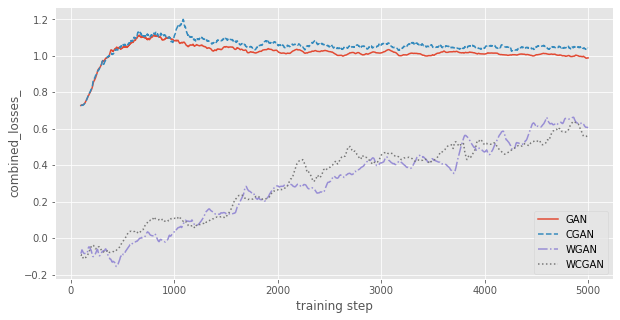

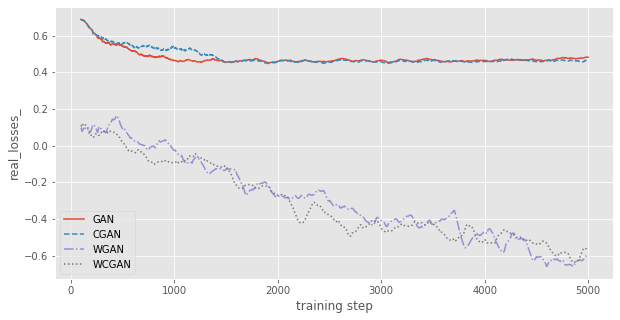

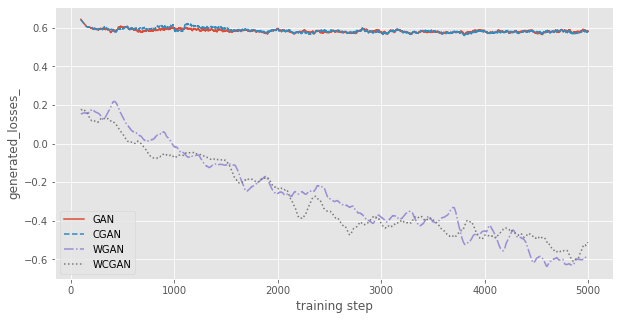

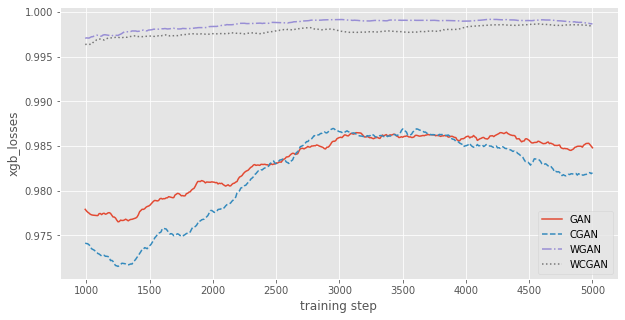

In [160]:

# Look at the smoothed losses

data_fields = ['combined_losses_', 'real_losses_', 'generated_losses_', 'xgb_losses']
sampling_intervals = [ 1, 1, 1, 10 ]
labels = [ 'GAN','CGAN','WGAN','WCGAN' ]
linestyles = ['-', '--', '-.', ':']

w = 100
for data_ix in range(len(data_fields)):
    data_sets = [ GAN_losses[data_ix], CGAN_losses[data_ix], WGAN_losses[data_ix], WCGAN_losses[data_ix]]

    plt.figure(figsize=(10,5))
    for data, label, linestyle in zip(data_sets, labels, linestyles):
        plt.plot( np.array(range(0,len(data)))*sampling_intervals[data_ix],
                 pd.DataFrame(data).rolling(w).mean(),
                 label=label, linestyle=linestyle )

    plt.ylabel(data_fields[data_ix])
    plt.xlabel('training step')
    plt.legend()
    plt.show()


<a id="Fig6"><h1>Figure 6: Accuracy of Generated Data Detection</h1></a><br>

<a href='#TOC'>Table of contents</a>

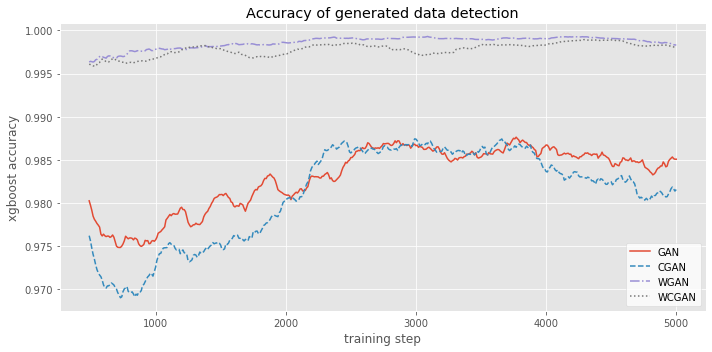

In [161]:

# Create a figure for the smoothed xgboost losses

data_fields = ['combined_losses_', 'real_losses_', 'generated_losses_', 'xgb_losses']
sampling_intervals = [ 1, 1, 1, 10 ]
labels = [ 'GAN','CGAN','WGAN','WCGAN' ]
linestyles = ['-', '--', '-.', ':']

w = 50
data_ix = 3

data_sets = [ GAN_losses[data_ix], CGAN_losses[data_ix], WGAN_losses[data_ix], WCGAN_losses[data_ix]]

plt.figure(figsize=(10,5))
for data, label, linestyle in zip(data_sets, labels, linestyles):
    plt.plot( np.array(range(0,len(data)))*sampling_intervals[data_ix],
             pd.DataFrame(data).rolling(w).mean(),
             label=label, linestyle=linestyle )

plt.ylabel(data_fields[data_ix])
plt.xlabel('training step')
legend = plt.legend() 
legend.get_frame().set_facecolor('white')

plt.title('Accuracy of generated data detection')
plt.ylabel('xgboost accuracy')
plt.tight_layout() ;
# plt.savefig('plots/GAN_accuracy.png')

<a id="Fig7"><h1>Figure 7: Differences in Critic Loss</h1></a><br>

<a href='#TOC'>Table of contents</a>

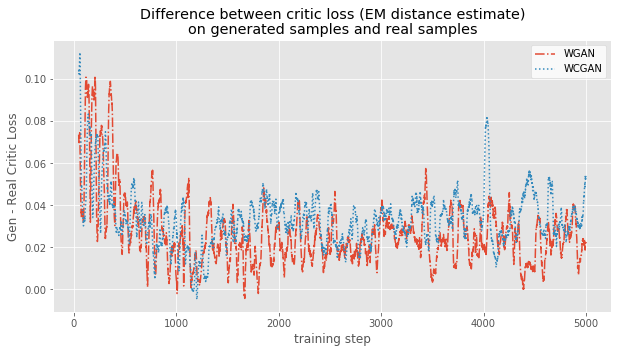

In [145]:

# Create a figure for the critic losses for the WGAN and WCGAN

w = 50

data_ix0 = 2
data_ix1 = 1
data_fields = ['combined_losses_', 'real_losses_', 'generated_losses_', 'xgb_losses']

i1, i2 = 2, 3
i2 += 1

labels = [ 'GAN','CGAN','WGAN','WCGAN' ][i1:i2]
data_sets0 = [ GAN_losses[data_ix0], CGAN_losses[data_ix0], WGAN_losses[data_ix0], WCGAN_losses[data_ix0]][i1:i2]
data_sets1 = [ GAN_losses[data_ix1], CGAN_losses[data_ix1], WGAN_losses[data_ix1], WCGAN_losses[data_ix1]][i1:i2]
linestyles = ['-', '--', '-.', ':'][i1:i2]

plt.figure(figsize=(10,5))
for data0, data1, label, linestyle in zip(data_sets0, data_sets1, labels, linestyles):
    plt.plot( range(0,len(data0)), 
             pd.DataFrame( np.array(data0)-np.array(data1) ).rolling(w).mean(),  
             label=label, linestyle=linestyle )
plt.title('Difference between critic loss (EM distance estimate)\non generated samples and real samples')
plt.xlabel('training step')
plt.ylabel('Gen - Real Critic Loss')
legend = plt.legend() 
legend.get_frame().set_facecolor('white')
# plt.savefig('plots/Delta_critic_loss_plot.png')